# Experiments <a name='table_of_contents'></a>

* ## Data Collection
* ## Feature Engineering
    1. [WHOIS: Keep vs Discard](#whois_keep_vs_discard)
        * [Conclusion](#whois_keep_vs_discard_conclusion)
    2. [WHOIS: KMeans vs Dummy Variable](#whois_kmeans_vs_dummy_variable)
        * [Conclusion](#whois_kmeans_vs_dummy_variable_conclusion)
    3. [WHOIS: ](#whois)
        * [Conclusion](#whois_conclusion)
    4. [Feature: Paper 2](#feature_paper_2)
        * [Conclusion](#feature_paper_2_conclusion)
    5. [Feature: Self-Defined](#feature_self_defined)
        * [Conclusion](#feature_self_defined_conclusion)
    6. [Feature Selection](#feature_selection)
        * [Conclusion](#feature_selection_conclusion)
    7. [Feature Groups](#feature_groups)
* ## Model Selection
    1. [Tuning: Support Vector Machine](#tuning_support_vector_machine)
        * [Conclusion](#tuning_support_vector_machine_conclusion)
    2. [Tuning: Logistic Regression](#tuning_logistic_regression)
        * [Conclusion](#tuning_logistic_regression_conclusion)
    3. [Tuning: Decision Tree](#tuning_decision_tree)
        * [Conclusion](#tuning_decision_tree_conclusion)
* ## Model Exportion
    1. [Export Classifiers](#export_classifiers)
    2. [Export Min-Max Scaler](#export_min_max_scaler)
* ## Service
* ## Unfixed Problems
    1. ClassifierUtility.py -> doCrossValidation -> not all scores need to multiply by 100
* ## Future Works
> 目前僅使用Logistic Regression的係數去對3種演算法做feature selection但口委建議可以對SVM取其係數或是畫出Decision Tree來個別挑3種演算法要使用的feature
    2. [Visualize Decision Tree](#visualize_decision_tree)
    3. [Feature Selection: SVM](#feature_selection_svm)

In [1]:
import os
import sys
import traceback
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from sklearn import datasets

from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

if "./modules" not in sys.path:
    sys.path.append("./modules")    

from BasicUtility import BasicUtility
from ClassifierUtility import ClassifierUtility
from ClustererUtility import ClustererUtility
from TuningUtility import TuningUtility

%matplotlib inline

### Load data

In [2]:
'''df_c = BasicUtility.readData('./dataset/feature_dirty.json')
df_c['label'] = 1

df_l = pd.concat([
    BasicUtility.readData('./dataset/feature_dirty_legitimate.json'), 
    BasicUtility.readData('./dataset/feature_dirty_momo.json')], ignore_index=True)
df_l['label'] = 0

df = df_l
df = df.loc[:, [
    'label',
    'url',
    'hostname',
    'length_of_fqdn',
    'replica_in_fqdn',
    'num_of_currencies_seen',
    'num_of_duplicate_prices_seen',
    'percent_savings',
    'contain_emails',
    'large_iframes',
    'under_a_year',
    'china_registered',
    'in_top_one_million'
]]

df.to_csv(path_or_buf='./dataset/feature_legitimate_paper1.csv', index=False)
'''

"df_c = BasicUtility.readData('./dataset/feature_dirty.json')\ndf_c['label'] = 1\n\ndf_l = pd.concat([\n    BasicUtility.readData('./dataset/feature_dirty_legitimate.json'), \n    BasicUtility.readData('./dataset/feature_dirty_momo.json')], ignore_index=True)\ndf_l['label'] = 0\n\ndf = df_l\ndf = df.loc[:, [\n    'label',\n    'url',\n    'hostname',\n    'length_of_fqdn',\n    'replica_in_fqdn',\n    'num_of_currencies_seen',\n    'num_of_duplicate_prices_seen',\n    'percent_savings',\n    'contain_emails',\n    'large_iframes',\n    'under_a_year',\n    'china_registered',\n    'in_top_one_million'\n]]\n\ndf.to_csv(path_or_buf='./dataset/feature_legitimate_paper1.csv', index=False)\n"

### Set classifiers

In [3]:
classifier_svm = svm.SVC(C=2.0, probability=True)
classifier_lr = LogisticRegression()
classifier_dt = tree.DecisionTreeClassifier()

utility_svm = ClassifierUtility(classifier_svm)
utility_lr = ClassifierUtility(classifier_lr)
utility_dt = ClassifierUtility(classifier_dt)

In [4]:
df_counterfeit = BasicUtility.readData('./dataset/feature_counterfeit_paper1.csv')[:400]
df_legitimate = BasicUtility.readData('./dataset/feature_legitimate_paper1.csv')[:400] 
df_800 = pd.concat([df_counterfeit, df_legitimate], ignore_index=True)
df_800 = df_800.loc[:, [
    'label',
    'url',
    'hostname',
    'length_of_fqdn',
    'replica_in_fqdn',
    'num_of_currencies_seen',
    'num_of_duplicate_prices_seen',
    'percent_savings',
    'contain_emails',
    'large_iframes',
    'under_a_year',
    'china_registered',
    'in_top_one_million'
]]

df_800['replica_in_fqdn'] = df_800['replica_in_fqdn'].map({True: 1, False: 0})
df_800['large_iframes'] = df_800['large_iframes'].map({True: 1, False: 0})
df_800['in_top_one_million'] = df_800['in_top_one_million'].map({True: 1, False: 0})

### 1. WHOIS: Keep vs Discard <a name="whois_keep_vs_discard"></a>
> Why? 由於撈資料時這兩個欄位的missing value比例很高，而論文中WHOIS是significant的欄位  
> 驗證WHOIS資訊(**under_a_year**, **china_registered**)對model performance(**accuracy**, **precision**, **recall**)的影響
> * 如果對model影響不大則可以discard
> * 影響很大就需要選擇一個適合的方式填missing values

### Get missing value rate

In [5]:
wanted_columns = (df_800.columns != 'label') & (df_800.columns != 'url') & (df_800.columns != 'hostname')
wanted_columns = df_800.columns[wanted_columns]
missing_value_rate = BasicUtility.getMissingValueRate(df_800, wanted_columns)
#missing_value_rate['Proportion(%)'] = missing_value_rate['Proportion(%)']*100
missing_value_rate.columns.name = 'Missing Value'
missing_value_rate.sort_values(by=['Amount'], ascending=False)

Missing Value,Amount,Proportion(%)
china_registered,612,76.500
under_a_year,357,44.625
percent_savings,7,0.875
num_of_currencies_seen,2,0.250
num_of_duplicate_prices_seen,2,0.250
contain_emails,2,0.250
length_of_fqdn,0,0.000
replica_in_fqdn,0,0.000
large_iframes,0,0.000
in_top_one_million,0,0.000


### Ignore samples with missing values

In [6]:
row_condition = pd.notna(df_800['label'])
for column in df_800.columns:
    row_condition = (row_condition & pd.notna(df_800[column]))
df_without_missing_values = df_800.copy().loc[row_condition, :]

### Do feature scaling

In [7]:
#col_condition = (df_without_missing_values.columns != 'label') & (df_without_missing_values.columns != 'url') & (df_without_missing_values.columns != 'hostname')
#df_without_missing_values_scaled = BasicUtility.doFeatureScaling(df_without_missing_values.loc[:, col_condition])
#df_without_missing_values_scaled = pd.concat( [df_without_missing_values.loc[:, ['label', 'url', 'hostname']], df_without_missing_values_scaled], axis=1 )
df_without_missing_values_scaled = BasicUtility.doFeatureScaling(df_without_missing_values)

In [8]:
utility_lr.runExperiment(df_without_missing_values_scaled)

Metric(5-fold mean(%))             Accuracy             Precision             \
WHOIS                                  keep    discard       keep    discard   
all                               93.567251  78.040936  95.592105  79.461538   
w/o length_of_fqdn                93.567251  78.040936  95.592105  79.461538   
w/o replica_in_fqdn               93.567251  80.146199  95.592105  83.628205   
w/o in_top_one_million            93.567251  76.988304  95.592105  77.770362   
w/o num_of_currencies_seen        93.567251  79.619883  95.592105  82.330586   
w/o num_of_duplicate_prices_seen  93.040936  73.742690  94.644737  71.921444   
w/o percent_savings               93.040936  75.380117  94.644737  72.976190   
w/o contain_emails                93.567251  78.040936  95.592105  79.461538   
w/o large_iframes                 93.567251  78.040936  95.592105  79.461538   

Metric(5-fold mean(%))               Recall              F1 Score             
WHOIS                                  keep    discard       keep    discard  
all                               90.849673  72.745098  92.818230  75.658505  
w/o length_of_fqdn                90.849673  72.745098  92.818230  75.658505  
w/o replica_in_fqdn               90.849673  72.745098  92.818230  77.227132  
w/o in_top_one_million            90.849673  72.745098  92.818230  74.885395  
w/o num_of_currencies_seen        90.849673  72.745098  92.818230  76.857257  
w/o num_of_duplicate_prices_seen  90.849673  73.856209  92.306139  72.660484  
w/o percent_savings               90.849673  77.320261  92.306139  74.557230  
w/o contain_emails                90.849673  72.745098  92.818230  75.658505  
w/o large_iframes                 90.849673  72.745098  92.818230  75.658505

### Get coefficients from logistic regression

In [9]:
logistic_regression_coefficients = utility_lr.getModelCoefficients(df_without_missing_values_scaled)
logistic_regression_coefficients
pd.concat([missing_value_rate, logistic_regression_coefficients], axis=1).sort_values(by=['coefficients'], ascending=False)

,Amount,Proportion(%),coefficients
under_a_year,357,44.625,3.086861
china_registered,612,76.500,1.732457
percent_savings,7,0.875,0.876960
replica_in_fqdn,0,0.000,0.252460
num_of_currencies_seen,2,0.250,-0.037557
contain_emails,2,0.250,-0.143372
in_top_one_million,0,0.000,-0.393100
large_iframes,0,0.000,-0.469681
length_of_fqdn,0,0.000,-0.552036
num_of_duplicate_prices_seen,2,0.250,-1.187039


### See if other ML algortihms have the same trend

In [10]:
def WHOIS_Keep_Versus_Discard(dataframe):
    result_lr = utility_lr.runExperiment(dataframe)
    result_dt = utility_dt.runExperiment(dataframe)
    result_svm = utility_svm.runExperiment(dataframe)

    indexes = ["Logistic Regression", "Decision Tree", "SVM"]
    columns = result_svm.columns
    data = [
        result_lr.values.tolist()[0],
        result_dt.values.tolist()[0],
        result_svm.values.tolist()[0]
    ]
    
    return pd.DataFrame(data=data, columns=columns, index=indexes)

WHOIS_Keep_Versus_Discard(df_without_missing_values_scaled)

Metric(5-fold mean(%))   Accuracy             Precision                Recall  \
WHOIS                        keep    discard       keep    discard       keep   
Logistic Regression     93.567251  78.040936  95.592105  79.461538  90.849673   
Decision Tree           88.742690  75.847953  89.386800  78.292398  86.405229   
SVM                     93.567251  79.093567  95.592105  81.247253  90.849673   

Metric(5-fold mean(%))              F1 Score             
WHOIS                     discard       keep    discard  
Logistic Regression     72.745098  92.818230  75.658505  
Decision Tree           69.477124  87.388229  72.655380  
SVM                     72.745098  92.818230  76.393799

### Conclusion <a name="whois_keep_vs_discard_conclusion"></a>
[top](#table_of_contents)

### 2. WHOIS: K-means vs Dummy Variable <a name="whois_kmeans_vs_dummy_variable"></a>
> 選擇要以何種方式來填WHOIS的missing value
* Dummy Variable: 括充欄位，當missing value rate很高時將會使得該欄位失去significance
* K-means: 用其他欄位去做分群，以每個群label 1/0的比例去填missing value，當其他欄位與WHOIS的相關性不高則填入的missing value意義不大

### Create a smaller dataset to mimic larger dataset, higher missing value rate

In [11]:
row_condition = (pd.notna(df_800['under_a_year'])) | (pd.notna(df_800['china_registered']))
gb_label = df_800.loc[row_condition, :].groupby(['label'])
df_400 = gb_label.head(n=200)
missing_value_rate_400 = BasicUtility.getMissingValueRate(df_400, wanted_columns)

c = pd.concat([missing_value_rate_400, missing_value_rate], axis=1)
del c['Amount']
c.columns = ['dataset_400', 'dataset_800']
c.columns.name = 'Missing Value Rate(%)'
c

Missing Value Rate(%),dataset_400,dataset_800
length_of_fqdn,0.00,0.000
replica_in_fqdn,0.00,0.000
num_of_currencies_seen,0.25,0.250
num_of_duplicate_prices_seen,0.25,0.250
percent_savings,1.00,0.875
contain_emails,0.25,0.250
large_iframes,0.00,0.000
under_a_year,0.00,44.625
china_registered,57.50,76.500
in_top_one_million,0.00,0.000


### Fill missing values
* Others(low missing value rate)
    * Numerical: fill with mean
    * Boolean: fill with zero

In [12]:
columns_with_low_missing_value_rate = {
    'names': ['num_of_currencies_seen', 'num_of_duplicate_prices_seen', 'percent_savings', 'contain_emails'],
    'types': ['numerical', 'numerical', 'numerical', 'categorical']
}

df_800_filled = BasicUtility.fillMissingValues(
    dataframe=df_800, 
    column_names=columns_with_low_missing_value_rate['names'], 
    column_types=columns_with_low_missing_value_rate['types']
)

df_400_filled = BasicUtility.fillMissingValues(
    dataframe=df_400, 
    column_names=columns_with_low_missing_value_rate['names'], 
    column_types=columns_with_low_missing_value_rate['types']
)

#BasicUtility.getMissingValueRate(df_400_filled, wanted_columns)

### Fill missing values
* WHOIS(high missing value rate)
    * Initial: dummy variable
    * Alternative: kmeans

In [13]:
df_800_dummy = df_800_filled.copy()
df_800_dummy['under_a_year_dummy'] = df_800_filled['under_a_year'].map(arg={ 1: 0, 0: 0, None: 1 })
df_800_dummy['china_registered_dummy'] = df_800_filled['china_registered'].map(arg={ 1: 0, 0: 0, None: 1 })
df_800_dummy = df_800_dummy.fillna(0)

df_400_dummy = df_400_filled.copy()
df_400_dummy['under_a_year_dummy'] = df_400_filled['under_a_year'].map(arg={ 1: 0, 0: 0, None: 1 })
df_400_dummy['china_registered_dummy'] = df_400_filled['china_registered'].map(arg={ 1: 0, 0: 0, None: 1 })
df_400_dummy = df_400_dummy.fillna(0)

#BasicUtility.getMissingValueRate(df_400_dummy, wanted_columns)

### Average Silhouette Method(平均側影法): 決定K要取多少
> This measure has a range of [-1, 1]
Silhouette coefficients (as these values are referred to as)
near +1 indicate that the sample is far away from the neighboring clusters.
A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and 
negative values indicate that those samples might have been assigned to the wrong cluster.

In [14]:
util_cluster = ClustererUtility()
df_800_kmeans = util_cluster.doDummyToClustering(df_800_dummy, max_K=4)
df_400_kmeans = util_cluster.doDummyToClustering(df_400_dummy, max_K=4)

   Silhouette Score
K                  
2          0.538354
3          0.613469
4          0.654701
               cluster_size  under_a_year  fill_under_a_year  \
cluster_label                                                  
0                        84          49.0           0.583333   
1                        63          14.0           0.222222   
2                         9           2.0           0.222222   
3                        32          20.0           0.625000   

               china_registered  fill_china_registered  
cluster_label                                           
0                          42.0               0.500000  
1                           5.0               0.079365  
2                           0.0               0.000000  
3                          20.0               0.625000  
   Silhouette Score
K                  
2          0.533106
3          0.602389
4          0.647411
               cluster_size  under_a_year  fill_under_a_year  \
cluster_l

### Do feature scaling

In [15]:
df_800_dummy_scaled = BasicUtility.doFeatureScaling(df_800_dummy)
df_400_dummy_scaled = BasicUtility.doFeatureScaling(df_400_dummy)
df_800_kmeans_scaled = BasicUtility.doFeatureScaling(df_800_kmeans)
df_400_kmeans_scaled = BasicUtility.doFeatureScaling(df_400_kmeans)

### Conclusion <a name="whois_kmeans_vs_dummy_variable_conclusion"></a>
[top](#table_of_contents)

In [16]:
def WHOIS_Kmeans_Versus_Dummy_Variable():
    iterables = [["Accuracy", "Precision", "Recall", "F1 Score"], ["k-means", "dummy variable"]]
    col_index = pd.MultiIndex.from_product(iterables=iterables, names=['Metric(5-fold mean(%))', 'Method'])
    row_index = ['dataset_400', 'dataset_800']
    df_result = pd.DataFrame()
    
    result_400_dummy = utility_lr.doABTesting(df_400_dummy_scaled, test_all=False)
    result_400_kmeans = utility_lr.doABTesting(df_400_kmeans_scaled, test_all=False)
    result_800_dummy = utility_lr.doABTesting(df_800_dummy_scaled, test_all=False)
    result_800_kmeans = utility_lr.doABTesting(df_800_kmeans_scaled, test_all=False)
    
    df_400_row = pd.DataFrame()
    for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']:
        df_400_row = pd.concat([df_400_row, result_400_kmeans[metric]], axis=1)
        df_400_row = pd.concat([df_400_row, result_400_dummy[metric]], axis=1)
        
    df_800_row = pd.DataFrame()
    for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']:
        df_800_row = pd.concat([df_800_row, result_800_kmeans[metric]], axis=1)
        df_800_row = pd.concat([df_800_row, result_800_dummy[metric]], axis=1)
    
    df_result = pd.concat([df_400_row, df_800_row], axis=0)
    df_result.columns = col_index
    df_result.index = row_index
    
    return df_result

WHOIS_Kmeans_Versus_Dummy_Variable()

Metric(5-fold mean(%)) Accuracy                 Precision                 \
Method                  k-means dummy variable    k-means dummy variable   
dataset_400               76.75          95.25  76.387446      96.896086   
dataset_800               72.00          83.25  71.695309      83.847145   

Metric(5-fold mean(%))  Recall                  F1 Score                 
Method                 k-means dummy variable    k-means dummy variable  
dataset_400               77.0           93.5  76.589199      95.163908  
dataset_800               73.0           82.5  72.239740      83.119038

In [17]:
def getCorrelationCoef(dataframe):
    df_copy = dataframe.copy()
    if 'label' in dataframe.columns:
        del df_copy["label"]
    if 'url' in dataframe.columns:
        del df_copy["url"]
    if 'hostname' in dataframe.columns:    
        del df_copy["hostname"]
    print(df_copy.columns)
    
    R = np.corrcoef(df_copy, rowvar=False)
    df_coef = pd.DataFrame(data=R, columns=df_copy.columns, index=df_copy.columns)
    
    return df_coef

matrix = getCorrelationCoef(df_without_missing_values_scaled)
correlation_between_whois_and_others = matrix[["under_a_year", "china_registered"]]
correlation_between_whois_and_others.columns.name = 'Correlation Coefficient'
correlation_between_whois_and_others

Index(['length_of_fqdn', 'replica_in_fqdn', 'num_of_currencies_seen',
       'num_of_duplicate_prices_seen', 'percent_savings', 'contain_emails',
       'large_iframes', 'under_a_year', 'china_registered',
       'in_top_one_million'],
      dtype='object')


Correlation Coefficient,under_a_year,china_registered
length_of_fqdn,0.010927,-0.104768
replica_in_fqdn,0.090794,0.141327
num_of_currencies_seen,0.366322,0.481356
num_of_duplicate_prices_seen,-0.126726,-0.112299
percent_savings,0.467246,0.494967
contain_emails,-0.066720,-0.055167
large_iframes,-0.150829,-0.124712
under_a_year,1.000000,0.781837
china_registered,0.781837,1.000000
in_top_one_million,-0.134535,-0.111239


### 3. WHOIS:  <a name="whois"></a>
> A: **under_a_year** is defined, B: **china_registered** is defined  
> all:  
> whois_well: A & B  
> under_a_year_undefined: ~A  
> china_registered_undefined: ~B  
> whois_undefined: (~A) & (~B) 

In [18]:
'''
def runExperiment3(dataframe):
    num_of_records = dataframe.shape[0]
    under_a_year_well = (dataframe['under_a_year_dummy'] == 0)
    china_registered_well = (dataframe['china_registered_dummy'] == 0)
    
    data = []
    columns = ['proportion of label_1', 'proportion of label_0']
    indexes = ['all', 'whois_well', 'under_a_year_undefined', 'china_registered_undefined', 'whois_undefined']
    conditions = [
        dataframe.index,
        (under_a_year_well & china_registered_well),
        ~under_a_year_well,
        ~china_registered_well,
        ((~under_a_year_well) & (~china_registered_well))
    ]
    
    for i in range(0, 5):
        condition = conditions[i]
        df_meets_condition = dataframe.loc[condition, 'label']
        counts = df_meets_condition.value_counts()
        proportion = [counts[1]/num_of_records, counts[0]/num_of_records]
        data.append(proportion)
        
        print(indexes[i])
        print(counts)
        print(proportion)
    
    
    return pd.DataFrame(data=data, columns=columns, index=indexes)

runExperiment3(df_800)
'''

"\ndef runExperiment3(dataframe):\n    num_of_records = dataframe.shape[0]\n    under_a_year_well = (dataframe['under_a_year_dummy'] == 0)\n    china_registered_well = (dataframe['china_registered_dummy'] == 0)\n    \n    data = []\n    columns = ['proportion of label_1', 'proportion of label_0']\n    indexes = ['all', 'whois_well', 'under_a_year_undefined', 'china_registered_undefined', 'whois_undefined']\n    conditions = [\n        dataframe.index,\n        (under_a_year_well & china_registered_well),\n        ~under_a_year_well,\n        ~china_registered_well,\n        ((~under_a_year_well) & (~china_registered_well))\n    ]\n    \n    for i in range(0, 5):\n        condition = conditions[i]\n        df_meets_condition = dataframe.loc[condition, 'label']\n        counts = df_meets_condition.value_counts()\n        proportion = [counts[1]/num_of_records, counts[0]/num_of_records]\n        data.append(proportion)\n        \n        print(indexes[i])\n        print(counts)\n        p

In [19]:
'''
def runExperiment4(dataframe):
    under_a_year_well = (dataframe['under_a_year_dummy'] == 0)
    china_registered_well = (dataframe['china_registered_dummy'] == 0)
    
    data = []
    columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    indexes = ['all', 'whois_well', 'under_a_year_undefined', 'china_registered_undefined', 'whois_undefined']
    conditions = [
        dataframe.index,
        (under_a_year_well & china_registered_well),
        ~under_a_year_well,
        ~china_registered_well,
        ((~under_a_year_well) & (~china_registered_well))
    ]
    
    for i in range(0, 5):
        row_condition = conditions[i]
        col_condition = (dataframe.columns != 'under_a_year_dummy') & (dataframe.columns != 'china_registered_dummy')
        df_meets_condition = dataframe.loc[row_condition, col_condition]
        
        df_testing_result = utility_svm.doABTesting(df_meets_condition, test_all=False)
        data.append(df_testing_result.values.tolist()[0])
        print(indexes[i])
        print(df_testing_result)
        print(df_testing_result.values.tolist())
        
    return pd.DataFrame(data=data, columns=columns, index=indexes)
        
runExperiment4(df_800)
'''

"\ndef runExperiment4(dataframe):\n    under_a_year_well = (dataframe['under_a_year_dummy'] == 0)\n    china_registered_well = (dataframe['china_registered_dummy'] == 0)\n    \n    data = []\n    columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']\n    indexes = ['all', 'whois_well', 'under_a_year_undefined', 'china_registered_undefined', 'whois_undefined']\n    conditions = [\n        dataframe.index,\n        (under_a_year_well & china_registered_well),\n        ~under_a_year_well,\n        ~china_registered_well,\n        ((~under_a_year_well) & (~china_registered_well))\n    ]\n    \n    for i in range(0, 5):\n        row_condition = conditions[i]\n        col_condition = (dataframe.columns != 'under_a_year_dummy') & (dataframe.columns != 'china_registered_dummy')\n        df_meets_condition = dataframe.loc[row_condition, col_condition]\n        \n        df_testing_result = utility_svm.doABTesting(df_meets_condition, test_all=False)\n        data.append(df_testing_result.val

### Conclusion <a name="whois_conclusion"></a>
This experiment only tells why we want to fill the missing values of whois

[top](#table_of_contents)

### 4. Feature: Paper 2 <a name="feature_paper_2"></a>
> add features from **'Learning to Detect and Measure Fake Ecommerce Websites in
Search-Engine Results'**
>
* **has_social_media**: whether a website provides links to **Facebook**, **Instagram** and **Line** fanpage of its brand
* **has_mobile_app**: whether a website provides links to **Google Play** and **Apple Store** to download their mobile apps
* **has_payment_option**: whether a website provides links to **付款方式**
* **contain_phone_numbers**: whether a website contains contact numbers

### Load data

In [20]:
df_counterfeit_paper2 = BasicUtility.readData('./dataset/feature_counterfeit_paper2.csv')
df_legitimate_paper2 = BasicUtility.readData('./dataset/feature_legitimate_paper2.csv')
df_800_paper2 = pd.concat([df_counterfeit_paper2, df_legitimate_paper2], ignore_index=True)

### Merge old features with new ones

In [21]:
df_800_paper2 = pd.merge(
    left=df_800_dummy_scaled, 
    right=df_800_paper2.groupby('url').first().reset_index(), 
    on=['url', 'hostname'], 
    how='left'
)

### Get missing value rate of new features to decide how to fill their missing values

In [22]:
BasicUtility.getMissingRates(
    dataframe=df_800_paper2, 
    column_names=['has_social_media', 'has_mobile_app', 'has_payment_option', 'contain_phone_numbers']
)

,Amount,Proportion(%)
has_social_media,2,0.25
has_mobile_app,2,0.25
has_payment_option,8,1.00
contain_phone_numbers,8,1.00


### Fill missing values

In [23]:
df_800_paper2_filled = BasicUtility.fillMissingValues(
    dataframe=df_800_paper2, 
    column_names=['has_social_media', 'has_mobile_app', 'has_payment_option', 'contain_phone_numbers'],
    column_types=['categorical', 'categorical', 'categorical', 'categorical']
)

### Do feature scaling

In [24]:
df_800_paper2_scaled = BasicUtility.doFeatureScaling(df_800_paper2_filled)

In [25]:
t = utility_lr.doABTesting(df_800_paper2_scaled, ['has_social_media', 'has_mobile_app', 'has_payment_option', 'contain_phone_numbers'])
t.columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
t.columns.name = 'Metric(5-fold mean(%))'
t

Metric(5-fold mean(%)),Accuracy,Precision,Recall,F1 Score
all,90.875,89.486234,92.75,91.052802
w/o has_social_media,84.625,85.736011,83.25,84.379486
w/o has_mobile_app,91.000,89.651712,92.75,91.152139
w/o has_payment_option,91.000,89.713433,92.75,91.164258
w/o contain_phone_numbers,90.875,89.486234,92.75,91.052802


In [26]:
def runAll(dataframe, columns_for_testing=[]):
    experiments = {
        'SVM': utility_svm.doABTesting(dataframe, columns_for_testing),
        'LR': utility_lr.doABTesting(dataframe, columns_for_testing),
        'DT': utility_dt.doABTesting(dataframe, columns_for_testing)
    }
    
    indexes = experiments['SVM'].index
    metrics = experiments['SVM'].columns
    algorithms = experiments.keys()
    columns = pd.MultiIndex.from_product([metrics, algorithms])
    result = pd.DataFrame()
    
    for metric in metrics:
        for algorithm in algorithms:
            result = pd.concat([result, experiments[algorithm][metric]], axis=1)
    result.columns = columns
    
    return result

In [27]:
report = runAll(df_800_dummy_scaled)
report

test_accuracy                 test_precision  \
                                            LR      DT     SVM             LR   
all                                     83.250  83.750  81.125      83.847145   
w/o china_registered                    83.500  84.500  81.375      83.912987   
w/o contain_emails                      82.625  83.875  81.000      83.316465   
w/o in_top_one_million                  83.500  83.625  81.125      84.101920   
w/o large_iframes                       83.250  84.500  81.125      84.181288   
w/o length_of_fqdn                      82.250  82.250  81.000      82.075697   
w/o num_of_currencies_seen              84.250  83.125  83.250      86.151188   
w/o num_of_duplicate_prices_seen        81.375  81.750  80.500      81.821549   
w/o percent_savings                     83.500  80.875  81.250      83.899511   
w/o replica_in_fqdn                     83.500  84.875  81.250      84.241232   
w/o under_a_year                        71.750  71.500  69.875      72.528032   

                                                       test_recall         \
                                         DT        SVM          LR     DT   
all                               87.351720  79.599605       82.50  79.25   
w/o china_registered              87.691643  79.994495       83.00  80.50   
w/o contain_emails                86.567530  79.409817       81.75  80.50   
w/o in_top_one_million            87.140018  79.599605       82.75  79.25   
w/o large_iframes                 88.022233  79.599605       82.00  80.00   
w/o length_of_fqdn                87.288378  79.409129       82.50  75.50   
w/o num_of_currencies_seen        85.938646  85.798790       81.75  79.50   
w/o num_of_duplicate_prices_seen  84.653050  78.663875       80.75  78.00   
w/o percent_savings               83.712289  79.794671       83.00  76.75   
w/o replica_in_fqdn               88.686358  79.794671       82.50  80.00   
w/o under_a_year                  73.285612  69.582431       70.25  68.25   

                                           test_f1                        
                                    SVM         LR         DT        SVM  
all                               83.75  83.119038  82.895237  81.596743  
w/o china_registered              83.75  83.407485  83.782118  81.801500  
w/o contain_emails                83.75  82.454217  83.224757  81.494297  
w/o in_top_one_million            83.75  83.368537  82.795801  81.596743  
w/o large_iframes                 83.75  83.018464  83.699855  81.596743  
w/o length_of_fqdn                83.75  82.263477  80.934922  81.496225  
w/o num_of_currencies_seen        79.75  83.830772  82.426113  82.588779  
w/o num_of_duplicate_prices_seen  83.75  81.241188  81.030391  81.102725  
w/o percent_savings               83.75  83.411666  79.956260  81.698493  
w/o replica_in_fqdn               83.75  83.322082  84.012212  81.698493  
w/o under_a_year                  70.75  71.098495  70.508582  70.026709

In [28]:
report_paper2 = runAll(df_800_paper2_scaled, ['has_social_media', 'has_mobile_app', 'has_payment_option', 'contain_phone_numbers'])
report_paper2

test_accuracy                test_precision  \
                                     LR     DT     SVM             LR   
all                              90.875  88.00  90.375      89.486234   
w/o contain_phone_numbers        90.875  88.50  90.500      89.486234   
w/o has_mobile_app               91.000  89.00  90.500      89.651712   
w/o has_payment_option           91.000  87.75  90.250      89.713433   
w/o has_social_media             84.625  83.50  83.875      85.736011   

                                                test_recall                \
                                  DT        SVM          LR     DT    SVM   
all                        88.596241  89.968204       92.75  87.25  91.00   
w/o contain_phone_numbers  89.088557  89.805867       92.75  87.75  91.50   
w/o has_mobile_app         89.837882  89.805867       92.75  88.00  91.50   
w/o has_payment_option     88.171797  89.741764       92.75  87.25  91.00   
w/o has_social_media       85.587046  84.398332       83.25  81.00  83.25   

                             test_f1                        
                                  LR         DT        SVM  
all                        91.052802  87.904972  90.428606  
w/o contain_phone_numbers  91.052802  88.398122  90.603765  
w/o has_mobile_app         91.152139  88.888304  90.603765  
w/o has_payment_option     91.164258  87.696621  90.318955  
w/o has_social_media       84.379486  83.013569  83.762542

### Find out which social media is in dominant

In [29]:
df_label0 = pd.concat([
    BasicUtility.readData('./dataset/social_media_momo.json'),
    BasicUtility.readData('./dataset/social_media_yahoo.json')
], ignore_index=True)
df_label1 = BasicUtility.readData('./dataset/social_media.json')

In [30]:
df_label0 = df_label0.loc[:, ['fb', 'ig', 'line']]
df_label0['at_least_one_social_media'] = (df_label0['fb']) | (df_label0['ig']) | (df_label0['line'])
proportion_label0 = df_label0.apply('sum')/df_label0.shape[0]

df_label1 = df_label1.loc[:, ['fb', 'ig', 'line']]
df_label1['at_least_one_social_media'] = (df_label1['fb']) | (df_label1['ig']) | (df_label1['line'])
proportion_label1 = df_label1.apply('sum')/df_label1.shape[0]

df_social_media_proportion = pd.concat([proportion_label1, proportion_label0], axis=1)
df_social_media_proportion.columns = ['Counterfeit', 'Legitimate']
df_social_media_proportion.index.name = 'Proportion of Links(%)'
df_social_media_proportion.columns.name = 'Type of Website'
df_social_media_proportion*100

Type of Website,Counterfeit,Legitimate
Proportion of Links(%),,
fb,2.179177,74.423963
ig,0.726392,26.036866
line,6.295400,40.552995
at_least_one_social_media,7.748184,80.184332


### Conclusion <a name="feature_paper_2_conclusion"></a>
[top](#table_of_contents)

In [31]:
utility_lr.getModelCoefficients(df_800_paper2_scaled).sort_values(by=['coefficients'], ascending=False)

,coefficients
under_a_year,4.137645
under_a_year_dummy,1.696315
percent_savings,1.256759
china_registered,0.569836
num_of_currencies_seen,0.486588
china_registered_dummy,0.257917
replica_in_fqdn,0.163886
contain_phone_numbers,-0.053793
in_top_one_million,-0.251062
has_payment_option,-0.731565


### 5. Feature: Self-Defined <a name="feature_self_defined"></a>
> add self-defined features, these kinds of features comes from observation of counterfeit websites
>
> how to quantify "simplicity"?
> * **node_counts**: number of DOM nodes in a website
> * **dom_height**: height(depth) of DOM
> * **text_tag_ratio**: text length/node counts
> * **text_length**: inner text length under html “body” element

In [32]:
df_counterfeit_self = BasicUtility.readData('./dataset/feature_counterfeit_self.csv')
df_legitimate_self = BasicUtility.readData('./dataset/feature_legitimate_self.csv')
df_800_self = pd.concat([df_counterfeit_self, df_legitimate_self], ignore_index=True)

In [33]:
df_800_self = pd.merge(
    left=df_800_dummy_scaled, 
    right=df_800_self.groupby('url').first().reset_index(), 
    on=['url', 'hostname'], 
    how='left'
)

In [34]:
BasicUtility.getMissingRates(df_800_self, ['node_counts', 'dom_height', 'text_tag_ratio'])

,Amount,Proportion(%)
node_counts,2,0.25
dom_height,2,0.25
text_tag_ratio,4,0.50


In [35]:
df_800_self_filled = BasicUtility.fillMissingValues(df_800_self, ['node_counts', 'dom_height', 'text_tag_ratio'], ['numerical', 'numerical', 'numerical'])

In [36]:
df_800_self_filled['text_length'] = df_800_self_filled['node_counts'] * df_800_self_filled['text_tag_ratio']
del df_800_self_filled['text_tag_ratio']

In [37]:
#col_conditions = (df_800_self.columns != 'url') & (df_800_self.columns != 'hostname') & (df_800_self.columns != 'label')
#df_800_self.loc[:, col_conditions] = BasicUtility.doFeatureScaling(df_800_self.loc[:, col_conditions])
df_800_self_scaled = BasicUtility.doFeatureScaling(df_800_self_filled)

In [38]:
t = utility_lr.doABTesting(df_800_self_scaled, ['node_counts', 'dom_height', 'text_length'])
t.columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
t.columns.name = 'Metric(5-fold mean(%))'
t

Metric(5-fold mean(%)),Accuracy,Precision,Recall,F1 Score
all,89.375,88.755166,90.25,89.463128
w/o node_counts,87.125,87.080951,87.25,87.131884
w/o dom_height,88.000,88.826624,87.00,87.829093
w/o text_length,89.750,89.387010,90.25,89.781759


In [39]:
report_self = runAll(df_800_self_scaled, ['node_counts', 'dom_height', 'text_length'])
report_self

test_accuracy                 test_precision             \
                           LR      DT     SVM             LR         DT   
all                    89.375  89.000  86.125      88.755166  88.089381   
w/o dom_height         88.000  87.875  84.250      88.826624  86.615268   
w/o node_counts        87.125  86.250  84.875      87.080951  86.925409   
w/o text_length        89.750  87.625  87.000      89.387010  86.116186   

                           test_recall                  test_f1             \
                       SVM          LR     DT    SVM         LR         DT   
all              87.738684       90.25  91.00  84.00  89.463128  89.321622   
w/o dom_height   84.602182       87.00  89.75  83.75  87.829093  88.052325   
w/o node_counts  85.165737       87.25  86.00  84.50  87.131884  86.237627   
w/o text_length  88.491188       90.25  90.25  85.00  89.781759  87.997615   

                            
                       SVM  
all              85.751461  
w/o dom_height   84.156301  
w/o node_counts  84.781502  
w/o text_length  86.654577

### Conclusion <a name="feature_self_defined_conclusion"></a>
[top](#table_of_contents)

In [40]:
utility_lr.getModelCoefficients(df_800_self_scaled).sort_values(by=['coefficients'], ascending=False)

,coefficients
under_a_year,4.325452
under_a_year_dummy,1.839859
num_of_currencies_seen,1.014754
china_registered,0.968805
percent_savings,0.597804
replica_in_fqdn,0.360022
china_registered_dummy,0.292282
in_top_one_million,-0.205392
text_length,-1.197715
large_iframes,-1.278468


In [41]:
'''df_800_text = df_800_self.copy()
#df_text = df_800_self.copy()
df_text['text_length'] = df_text['node_counts']*df_text['text_tag_ratio']'''
gb_text = df_800_self_filled.loc[:, ['label', 'text_length']].groupby(['label'])
print(gb_text.mean())
print(gb_text.std())
#text_length is random, so it's not significant

       text_length
label             
0      1605.298544
1      1171.723240
       text_length
label             
0      1858.128295
1      1411.968798


### 6. Feature Selection <a name="feature_selection"></a>
> * 所有feature放在一起train
> * 以coef的絕對值排序刪除feature
> * 到n_sample:n_feature=30:1

In [42]:
df_800_all_scaled = pd.concat([
    df_800_paper2_scaled,
    df_800_self_scaled.loc[:, ['node_counts', 'dom_height', 'text_length']],
], axis=1)
runAll(df_800_all_scaled)

test_accuracy                 test_precision  \
                                            LR      DT     SVM             LR   
all                                     91.500  88.875  91.000      90.836150   
w/o china_registered                    91.375  89.000  90.625      90.616337   
w/o contain_emails                      91.500  88.250  90.750      90.836150   
w/o contain_phone_numbers               91.500  89.375  90.750      90.836150   
w/o dom_height                          91.250  87.625  90.875      89.771251   
w/o has_mobile_app                      91.125  88.750  90.875      90.733082   
w/o has_payment_option                  91.750  88.375  90.750      91.249645   
w/o has_social_media                    89.375  89.375  86.250      88.748973   
w/o in_top_one_million                  91.625  89.750  90.875      90.846140   
w/o large_iframes                       91.500  88.875  90.875      90.836150   
w/o length_of_fqdn                      91.375  88.250  90.625      90.572420   
w/o node_counts                         91.500  89.250  90.625      90.585334   
w/o num_of_currencies_seen              91.500  89.500  90.625      90.544734   
w/o num_of_duplicate_prices_seen        91.500  89.000  90.750      90.836150   
w/o percent_savings                     91.750  87.125  90.750      91.046872   
w/o replica_in_fqdn                     91.625  88.625  90.875      91.002730   
w/o text_length                         91.500  89.000  90.750      90.585334   
w/o under_a_year                        86.500  87.000  85.500      84.580732   

                                                       test_recall         \
                                         DT        SVM          LR     DT   
all                               88.900518  90.666921       92.50  89.00   
w/o china_registered              88.320690  90.209372       92.50  90.00   
w/o contain_emails                88.348561  90.040706       92.50  88.25   
w/o contain_phone_numbers         89.506500  90.040706       92.50  89.25   
w/o dom_height                    87.906193  90.439073       93.25  87.25   
w/o has_mobile_app                89.273119  90.238514       91.75  88.25   
w/o has_payment_option            87.982809  90.040706       92.50  89.00   
w/o has_social_media              87.879089  87.449962       90.25  92.00   
w/o in_top_one_million            90.074814  90.238514       92.75  89.50   
w/o large_iframes                 89.520702  90.238514       92.50  88.25   
w/o length_of_fqdn                87.479202  90.011494       92.50  89.75   
w/o node_counts                   89.140222  90.179332       92.75  89.75   
w/o num_of_currencies_seen        89.623052  90.428451       92.75  89.50   
w/o num_of_duplicate_prices_seen  89.866048  90.040706       92.50  88.25   
w/o percent_savings               88.751227  90.040706       92.75  85.25   
w/o replica_in_fqdn               88.906884  90.238514       92.50  88.50   
w/o text_length                   89.507687  90.225194       92.75  88.50   
w/o under_a_year                  86.515465  82.327198       89.50  87.75   

                                           test_f1                        
                                    SVM         LR         DT        SVM  
all                               91.50  91.609215  88.900224  91.038816  
w/o china_registered              91.25  91.497260  89.120416  90.677264  
w/o contain_emails                91.75  91.609215  88.238005  90.849279  
w/o contain_phone_numbers         91.75  91.609215  89.360036  90.849279  
w/o dom_height                    91.50  91.440719  87.566274  90.925608  
w/o has_mobile_app                91.75  91.199581  88.692137  90.956053  
w/o has_payment_option            91.75  91.829810  88.435364  90.849279  
w/o has_social_media              84.75  89.447964  89.710404  85.996344  
w/o in_top_one_million            91.75  91.743053  89.729895  90.956053  
w/o large_iframes                 91.75  91.60

### get coefficients of logistic regression

In [43]:
absolute_coefficients = utility_lr.getModelCoefficients(df_800_all_scaled).sort_values(by=['coefficients'], ascending=False)
absolute_coefficients

,coefficients
under_a_year,3.953647
under_a_year_dummy,1.579204
percent_savings,1.224316
num_of_currencies_seen,0.785567
china_registered,0.640425
china_registered_dummy,0.296518
replica_in_fqdn,0.263408
contain_phone_numbers,-0.042327
in_top_one_million,-0.112914
has_payment_option,-0.562959


### Sort absolute values of coefficients to eliminate undesired features

In [44]:
absolute_coefficients = utility_lr.getModelCoefficients(df_800_all_scaled).abs().sort_values(by=['coefficients'], ascending=False)
absolute_coefficients.columns = ['Absolute Coefficients']
absolute_coefficients

,Absolute Coefficients
under_a_year,3.953647
node_counts,2.692064
has_social_media,2.455635
dom_height,1.942607
has_mobile_app,1.719297
under_a_year_dummy,1.579204
length_of_fqdn,1.323884
num_of_duplicate_prices_seen,1.252205
percent_savings,1.224316
text_length,0.990876


In [45]:
coefficient_thresholds = [0.5, 1.0, 1.5, 2.0]
utility_used = utility_lr
df_feature_selection = pd.DataFrame()

for i in range(0, len(coefficient_thresholds)):
    columns_below_threshold = (absolute_coefficients < coefficient_thresholds[i])['Absolute Coefficients']
    columns_to_eliminate = absolute_coefficients.loc[columns_below_threshold, :].index.values.tolist()
    
    df_800_drop_scaled = df_800_all_scaled.drop(labels=columns_to_eliminate, axis=1)
    cv_result = utility_used.doCrossValidation(df_800_drop_scaled)
    cv_result = cv_result.T.apply(['mean', 'std']).loc[:, ['test_recall', 'train_recall', 'test_f1', 'train_f1']]
    cv_result = cv_result.T.stack()
    
    df_feature_selection = pd.concat([df_feature_selection, cv_result], axis=1)
    
df_feature_selection.columns = coefficient_thresholds
df_feature_selection.columns.name = 'Coefficient Threshold'
df_feature_selection/100
#df_feature_selection.loc[[('test_recall','mean'), ('train_recall','mean')], :]

Coefficient Threshold       0.5       1.0       1.5       2.0
test_recall  mean      0.927500  0.932500  0.925000  0.947500
             std       0.024044  0.034911  0.038528  0.034686
train_recall mean      0.929375  0.933750  0.925000  0.947500
             std       0.007526  0.007126  0.009632  0.008672
test_f1      mean      0.918433  0.918725  0.912487  0.882014
             std       0.022008  0.031099  0.034586  0.039453
train_f1     mean      0.920458  0.921083  0.913574  0.880905
             std       0.006609  0.006414  0.007561  0.008333

### Conclusion <a name="feature_selection_conclusion"></a>
[top](#table_of_contents)

### Feature Groups <a name="feature_groups"></a>
* 簡單說明Paper2的其他feature是因為missing value rate高所以不用,Paper1的則是因為和他們自己有預設brand name
* Define the meaning of the feature and how you get it clearly e.g. has_mobile_app
* Categorical: multiple classes, Boolean: 0-1 class

[top](#table_of_contents)

In [46]:
indexes = pd.MultiIndex.from_tuples([
    ('URL','length_of_fqdn'), 
    ('URL','replica_in_fqdn'), 
    ('Content Element','num_of_currencies_seen'), 
    ('Content Element','num_of_duplicate_prices_seen'), 
    ('Content Element','percent_savings'), 
    ('Content Element','contain_emails'), 
    ('Content Element','contain_phone_numbers'), 
    ('Content Element','has_social_media'), 
    ('Content Element','has_mobile_app'), 
    ('Content Element','has_payment_option'), 
    ('Content Element','large_iframes'), 
    ('Content Structure','node_counts'), 
    ('Content Structure','dom_height'), 
    ('Content Structure','text_length'), 
    ('WHOIS','in_top_one_million'), 
    ('WHOIS','china_registered'), 
    ('WHOIS','under_a_year')
], names=['Group', 'Name'])
columns = ['Type', 'Meaning']
feature_spec = [
    ['Numerical', 'length of fully qualified domain name'],
    ['Boolean', 'whether keyword "replica" appears in fqdn'],
    ['Numerical', 'how many kind of currencies shown in a website'],
    ['Numerical', 'the maximum number of duplicate prices seen in a website'],
    ['Numerical', 'number of percent off'],
    ['Boolean', 'whether a website contains email'],
    ['Boolean', 'whether a website contains contact numbers'],
    ['Boolean', 'links to **Facebook**, **Instagram** and **Line** fanpage of their brands'],
    ['Boolean', 'links to Google Play and Apple Store'],
    ['Boolean', 'whether a website has links to "付款方式"'],
    ['Boolean', 'whether a website contains large iframe'],
    ['Numerical', 'number of nodes in DOM'],
    ['Numerical', 'height of DOM tree'],
    ['Numerical', 'text length under body element'],
    ['Boolean', 'whether a website is in magestic million domain rankings'],
    ['Boolean', 'registration country is china'],
    ['Boolean', 'registration age is under a year']
]
pd.DataFrame(data=feature_spec, index=indexes, columns=columns)

Type  \
Group             Name                                      
URL               length_of_fqdn                Numerical   
                  replica_in_fqdn                 Boolean   
Content Element   num_of_currencies_seen        Numerical   
                  num_of_duplicate_prices_seen  Numerical   
                  percent_savings               Numerical   
                  contain_emails                  Boolean   
                  contain_phone_numbers           Boolean   
                  has_social_media                Boolean   
                  has_mobile_app                  Boolean   
                  has_payment_option              Boolean   
                  large_iframes                   Boolean   
Content Structure node_counts                   Numerical   
                  dom_height                    Numerical   
                  text_length                   Numerical   
WHOIS             in_top_one_million              Boolean   
                  china_registered                Boolean   
                  under_a_year                    Boolean   

                                                                                          Meaning  
Group             Name                                                                             
URL               length_of_fqdn                            length of fully qualified domain name  
                  replica_in_fqdn                       whether keyword "replica" appears in fqdn  
Content Element   num_of_currencies_seen           how many kind of currencies shown in a website  
                  num_of_duplicate_prices_seen  the maximum number of duplicate prices seen in...  
                  percent_savings                                           number of percent off  
                  contain_emails                                 whether a website contains email  
                  contain_phone_numbers                whether a website contains contact numbers  
                  has_social_media              links to **Facebook**, **Instagram** and **Lin...  
                  has_mobile_app                             links to Google Play and Apple Store  
                  has_payment_option                        whether a website has links to "付款方式"  
                  large_iframes                           whether a website contains large iframe  
Content Structure node_counts                                              number of nodes in DOM  
                  dom_height                                                   height of DOM tree  
                  text_length                                      text length under body element  
WHOIS             in_top_one_million            whether a website is in magestic million domai...  
                  china_registered                                  registration country is china  
                  under_a_year                                   registration age is under a year

In [47]:
columns_below_threshold = (absolute_coefficients < 1.0)['Absolute Coefficients']
columns_to_eliminate = absolute_coefficients.loc[columns_below_threshold, :].index.values.tolist()
    
df_800_drop_scaled = df_800_all_scaled.drop(labels=columns_to_eliminate, axis=1)
utility_tuning = TuningUtility(df_800_drop_scaled)

### 1. Tuning: Support Vector Machine <a name="tuning_support_vector_machine"></a>
* Parameters:
    1. C: penalty parameter of the error term, larger prone to overfitting smaller prone to underfitting, default=1.0
        * tradeoff between training error and flatness -> larger C, smaller training error
    2. kernel: default='rbf'
        * 'linear'
        * 'polynomial'
            * degree: default=3
            * gamma: default=1/n_features
            * coef0: default=0
        * 'rbf(Gaussian)'
            * gamma
        * 'sigmoid'
            * gamma
            * coef0

In [48]:
utility_tuning.tuneSVMParameters()

Accuracy  Precision  Recall   F1 Score    ROC AUC  Stability  \
kernel C                                                                    
rbf    0.25    85.500  82.327198   90.75  86.258859  96.425000   3.010399   
       0.50    90.625  90.428451   91.00  90.652870  96.681250   4.088857   
       1.00    90.625  89.819187   91.75  90.739216  96.815625   3.259601   
       2.00    91.000  89.857173   92.50  91.135473  97.056250   3.852759   
       4.00    91.000  89.857173   92.50  91.135473  97.181250   3.852759   
linear 0.25    89.375  90.212165   88.50  89.267390  97.000000   4.275658   
       0.50    90.500  89.805867   91.50  90.603765  97.178125   3.235545   
       1.00    91.000  89.857173   92.50  91.135473  97.340625   3.852759   
       2.00    91.000  89.857173   92.50  91.135473  97.365625   3.852759   
       4.00    90.750  90.065607   91.75  90.858542  97.346875   3.259601   
poly   0.25    59.875  55.584626   99.00  71.177398  93.878125   1.369306   
       0.50    68.500  62.011439   96.00  75.324197  94.503125   2.984334   
       1.00    83.500  77.510437   95.25  85.339595  94.821875   3.468609   
       2.00    87.000  82.221701   94.75  87.988595  94.400000   3.468609   
       4.00    86.875  82.039428   94.75  87.886959  94.787500   3.468609   

             Generalization  
kernel C                     
rbf    0.25          3.2500  
       0.50          3.3750  
       1.00          3.1250  
       2.00          3.7500  
       4.00          3.7500  
linear 0.25          3.2500  
       0.50          3.2500  
       1.00          3.7500  
       2.00          3.6875  
       4.00          2.8750  
poly   0.25          1.5625  
       0.50          2.8125  
       1.00          3.3750  
       2.00          3.3750  
       4.00          3.3750

### Conclusion <a name="tuning_support_vector_machine_conclusion"></a>
[top](#table_of_contents)

### 2. Tuning: Logistic Regression <a name="tuning_logistic_regression"></a>
* Parameters:
    1. C: inversion of regularization term, the smaller the larger  regularization, default=1.0
    2. solver: algorithm to use in the optimization problem, default='liblinear'
        * small datasets use 'libnear' and large use 'sag' & 'saga'
        * 'newton-cg', 'lbfgs' and 'sag' only handle L2 penalty
    3. penalty: norm used in penalization, default='l2'
    4. max_iter: maximum number of iterations taken for the solvers to converge, default=100

In [49]:
utility_tuning.tuneLogisticRegressionParameters()

Accuracy  Precision  Recall   F1 Score    ROC AUC  Stability  \
penalty C                                                                    
l2      0.25    91.000  90.066347   92.25  91.115102  96.871875   3.579455   
        0.50    91.375  90.320413   92.75  91.500012  97.100000   2.850439   
        1.00    91.750  90.572652   93.25  91.872479  97.159375   3.491060   
        2.00    91.875  90.791573   93.25  91.990139  97.268750   2.877716   
        4.00    92.250  91.253850   93.50  92.350867  97.390625   2.561738   
l1      0.25    91.000  89.297857   93.25  91.214350  96.529687   3.491060   
        0.50    91.625  90.355850   93.25  91.762058  97.128125   3.491060   
        1.00    91.625  90.795304   92.75  91.730696  97.390625   2.850439   
        2.00    92.625  91.987020   93.50  92.705275  97.500000   2.053960   
        4.00    92.250  91.509171   93.25  92.340153  97.587500   2.270738   

              Generalization  
penalty C                     
l2      0.25          3.3750  
        0.50          2.7500  
        1.00          3.5000  
        2.00          2.8750  
        4.00          2.6250  
l1      0.25          3.6250  
        0.50          3.5000  
        1.00          2.7500  
        2.00          2.0000  
        4.00          2.3125

### Conclusion <a name="parameter_logistic_regression_conclusion"></a>
[top](#table_of_contents)

### 3. Tuning: Decision Tree <a name="tuning_decision_tree"></a>
* Decision trees tend to overfit on data with a large number of features
* Balance your dataset before training to prevent the tree from being biased toward the classes that are dominant
* Parameters:
    1. criterion: default='gini', 'entropy'
    2. splitter: default='best', 'random' for large number of samples
    3. max_features: default=None, 'sqrt' for n_features > 50
    4. max_depth: default=None, try max_depth=3 as an initial tree depth
    5. min_samples_split: default=2
    6. min_samples_leaf: default=1, try min_samples_leaf=5 as an initial value

In [50]:
utility_tuning.tuneDecisionTreeParameters()

Accuracy  Precision  Recall   F1 Score    ROC AUC  \
max_depth min_samples_leaf                                                      
3         1                   84.875  89.736710   80.50  83.961968  91.606250   
          5                   84.625  89.542345   80.25  83.789835  93.093750   
          10                  85.625  90.026113   81.50  84.772604  93.071875   
4         1                   89.375  92.916514   85.75  89.019212  91.462500   
          5                   88.875  92.723697   85.00  88.445164  93.757812   
          10                  90.375  94.258556   86.25  89.976103  93.951562   
5         1                   90.000  90.923568   89.00  89.866756  91.632812   
          5                   88.875  89.852917   88.00  88.725415  94.326562   
          10                  90.375  91.569892   89.25  90.234268  94.403125   
6         1                   90.000  91.672046   88.25  89.875531  92.309375   
          5                   89.500  91.744071   87.25  89.294813  94.770313   
          10                  91.125  93.705566   88.25  90.853518  94.296875   
7         1                   89.500  90.113073   88.75  89.415435  91.639062   
          5                   89.125  90.664081   87.75  88.996172  94.275000   
          10                  90.625  92.195073   89.00  90.459918  94.200000   

                            Stability  Generalization  
max_depth min_samples_leaf                             
3         1                 12.292020          5.3750  
          5                 10.947317          5.6875  
          10                11.706035          4.5625  
4         1                  3.010399          3.6875  
          5                  5.000000          4.0625  
          10                 3.061862          2.8750  
5         1                  5.199159          4.3750  
          5                  6.590713          5.3750  
          10                 5.700877          3.4375  
6         1                  2.270738          5.1250  
          5                  4.275658          5.5000  
          10                 3.259601          2.8750  
7         1                  3.112475          7.1250  
          5                  4.952903          5.8750  
          10                 4.183300          2.5625

### Conclusion <a name="tuning_decision_tree_conclusion"></a>
[top](#table_of_contents)

In [51]:
'''
#df = pd.concat([readData('./dataset/feature_self_yahoo_.json'), readData('./dataset/feature_self_momo_.json')], ignore_index=True)
df = readData('./dataset/feature_self_.json')
df = df.drop(columns=['in_top_one_million', 'length_of_fqdn', 'replica_in_fqdn'])
df = df.loc[:, ['url', 'hostname', 'node_counts', 'dom_height', 'text_tag_ratio']]
#df.to_csv(path_or_buf='./dataset/feature_legitimate_self.csv', index=False)
df.to_csv(path_or_buf='./dataset/feature_counterfeit_self.csv', index=False)
'''
'''
#df = pd.concat([readData('./dataset/feature_paper2_yahoo.json'), readData('./dataset/feature_paper2_momo.json')], ignore_index=True)
df = readData('./dataset/feature_paper2.json')
df = df.drop(columns=['in_top_one_million', 'length_of_fqdn', 'replica_in_fqdn', 'label'])
df = df.loc[:, ['url', 'hostname', 'contain_phone_numbers', 'has_mobile_app', 'has_social_media', 'has_payment_option']]
field = 'has_mobile_app'
df[field] = df[field].map({True: 1, False: 0})
field = 'has_social_media'
df[field] = df[field].map({True: 1, False: 0})
df.to_csv(path_or_buf='./dataset/feature_counterfeit_paper2.csv', index=False)
'''

"\n#df = pd.concat([readData('./dataset/feature_paper2_yahoo.json'), readData('./dataset/feature_paper2_momo.json')], ignore_index=True)\ndf = readData('./dataset/feature_paper2.json')\ndf = df.drop(columns=['in_top_one_million', 'length_of_fqdn', 'replica_in_fqdn', 'label'])\ndf = df.loc[:, ['url', 'hostname', 'contain_phone_numbers', 'has_mobile_app', 'has_social_media', 'has_payment_option']]\nfield = 'has_mobile_app'\ndf[field] = df[field].map({True: 1, False: 0})\nfield = 'has_social_media'\ndf[field] = df[field].map({True: 1, False: 0})\ndf.to_csv(path_or_buf='./dataset/feature_counterfeit_paper2.csv', index=False)\n"

### Try model selection with GridSearchCV

In [52]:
test = utility_tuning.tuneParameters(algorithm='SVM')
print(test.best_params_)
utility_test = ClassifierUtility(classifier=test.best_estimator_)
utility_test.doABTesting(df_800_drop_scaled, test_all=False)

{'kernel': 'poly', 'C': 0.25}


,test_accuracy,test_precision,test_recall,test_f1
all,59.875,55.584626,99.0,71.177398


### 1. Export Classifiers <a name="export_classifiers"></a>
### use total 800 websites as training set to train the model instead of using 5-fold cv(640)

In [53]:
import pickle
from collections import OrderedDict

label_and_feature = BasicUtility.splitLabelFeature(df_800_drop_scaled)
classifiers = OrderedDict((
    ('LR', LogisticRegression(penalty='l2', C=4.0)),
    ('DT', tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=1)),
    ('SVM', svm.SVC(kernel='rbf', C=2.0, probability=True))
))

for key in classifiers.keys():
    classifiers[key].fit(label_and_feature['feature'].values.tolist(), label_and_feature['label'])
    
    file_path = "./model/"+key+".sav"
    print(file_path)
    with open(file_path, 'wb') as f:
        pickle.dump(classifiers[key], f)
        #pickle.dump(classifiers[key], f, protocol=2)

./model/LR.sav
./model/DT.sav
./model/SVM.sav


### Try to import a model
* The result is differnet when using same algorithm between utility_test and utility_lr is due to different parameters of classifiers

In [54]:
file_name = './model/LR.sav'
loaded_model = pickle.load(open(file_name, 'rb'))
utility_test.classifier = loaded_model
utility_test.doABTesting(df_800_drop_scaled)
#utility_lr.doABTesting(df_800_drop_scaled)
#utility_svm.doABTesting(df_800_drop_scaled)
#utility_dt.doABTesting(df_800_drop_scaled)

,test_accuracy,test_precision,test_recall,test_f1
all,92.250,91.253850,93.50,92.350867
w/o length_of_fqdn,91.625,91.175377,92.25,91.681085
w/o num_of_duplicate_prices_seen,92.250,91.272585,93.50,92.354918
w/o percent_savings,91.625,90.975693,92.50,91.699724
w/o under_a_year,88.000,85.587861,91.50,88.412549
w/o has_mobile_app,92.125,91.633013,92.75,92.172701
w/o has_social_media,89.500,89.126334,90.00,89.539610
w/o node_counts,91.500,90.319351,93.00,91.628337
w/o dom_height,91.625,90.136458,93.50,91.778210


In [55]:
df_800_drop_scaled.columns

Index(['label', 'url', 'hostname', 'length_of_fqdn',
       'num_of_duplicate_prices_seen', 'percent_savings', 'under_a_year',
       'under_a_year_dummy', 'has_mobile_app', 'has_social_media',
       'node_counts', 'dom_height'],
      dtype='object')

### Try to use df_800_all_filled to train model but not good

In [56]:
df_800_filled['under_a_year_dummy'] = df_800_filled['under_a_year'].isnull()
df_800_filled.loc[df_800_filled['under_a_year_dummy'], ['under_a_year']] = 0
df_800_filled.loc[:, ['under_a_year', 'under_a_year_dummy']]

,under_a_year,under_a_year_dummy
0,1.0,False
1,1.0,False
2,1.0,False
3,1.0,False
4,1.0,False
5,1.0,False
6,0.0,True
7,1.0,False
8,0.0,True
9,1.0,False


In [57]:
df_800_all_filled = pd.concat([
    df_800_filled.loc[:, ['url', 'label', 'length_of_fqdn', 'num_of_duplicate_prices_seen', 'percent_savings', 'under_a_year', 'under_a_year_dummy']],
    df_800_paper2_filled.loc[:, ['has_mobile_app', 'has_social_media']],
    df_800_self_filled.loc[:, ['node_counts', 'dom_height']],
], axis=1)

df_800_all_filled = df_800_all_filled.astype({
    'url': 'object',
    'label': 'int64',
    'length_of_fqdn': 'int64',
    'num_of_duplicate_prices_seen': 'int64',
    'percent_savings': 'float64',
    'under_a_year': 'int64',
    'under_a_year_dummy': 'int64',
    'has_mobile_app': 'int64',
    'has_social_media': 'int64',
    'node_counts': 'int64',
    'dom_height': 'int64'
})

In [58]:
utility_svm.doABTesting(df_800_all_filled, test_all=False)

,test_accuracy,test_precision,test_recall,test_f1
all,73.375,88.173026,54.0,66.659553


### 2. Export min-max scaler <a name="export_min_max_scaler"></a>

In [59]:
scaler = MinMaxScaler()
X = df_800_all_filled.drop(columns=['url', 'label']).values.tolist()
scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [60]:
file_path = "./model/MinMaxScaler.sav"
print(file_path)
with open(file_path, 'wb') as f:
    pickle.dump(scaler, f, protocol=2)

./model/MinMaxScaler.sav


### Fit the feature scaler dynamically

In [61]:
loaded_model = pickle.load(open(file_path, 'rb'))
print(loaded_model.data_min_)
print(loaded_model.data_max_)
loaded_model.partial_fit([[100, 70, 0, 0, 0, 0, 0, 8000, 10]])
print(loaded_model.data_min_)
print(loaded_model.data_max_)

[ 5.  0.  0.  0.  0.  0.  0.  3.  0.]
[  3.50000000e+01   6.60000000e+01   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   7.80300000e+03
   6.60000000e+01]
[ 5.  0.  0.  0.  0.  0.  0.  3.  0.]
[  1.00000000e+02   7.00000000e+01   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   8.00000000e+03
   6.60000000e+01]


### 1. Visualize Decision Tree <a name="visualize_decision_tree"></a>
* sudo apt-get install graphviz
* pip install graphviz
* pip install pydotplus

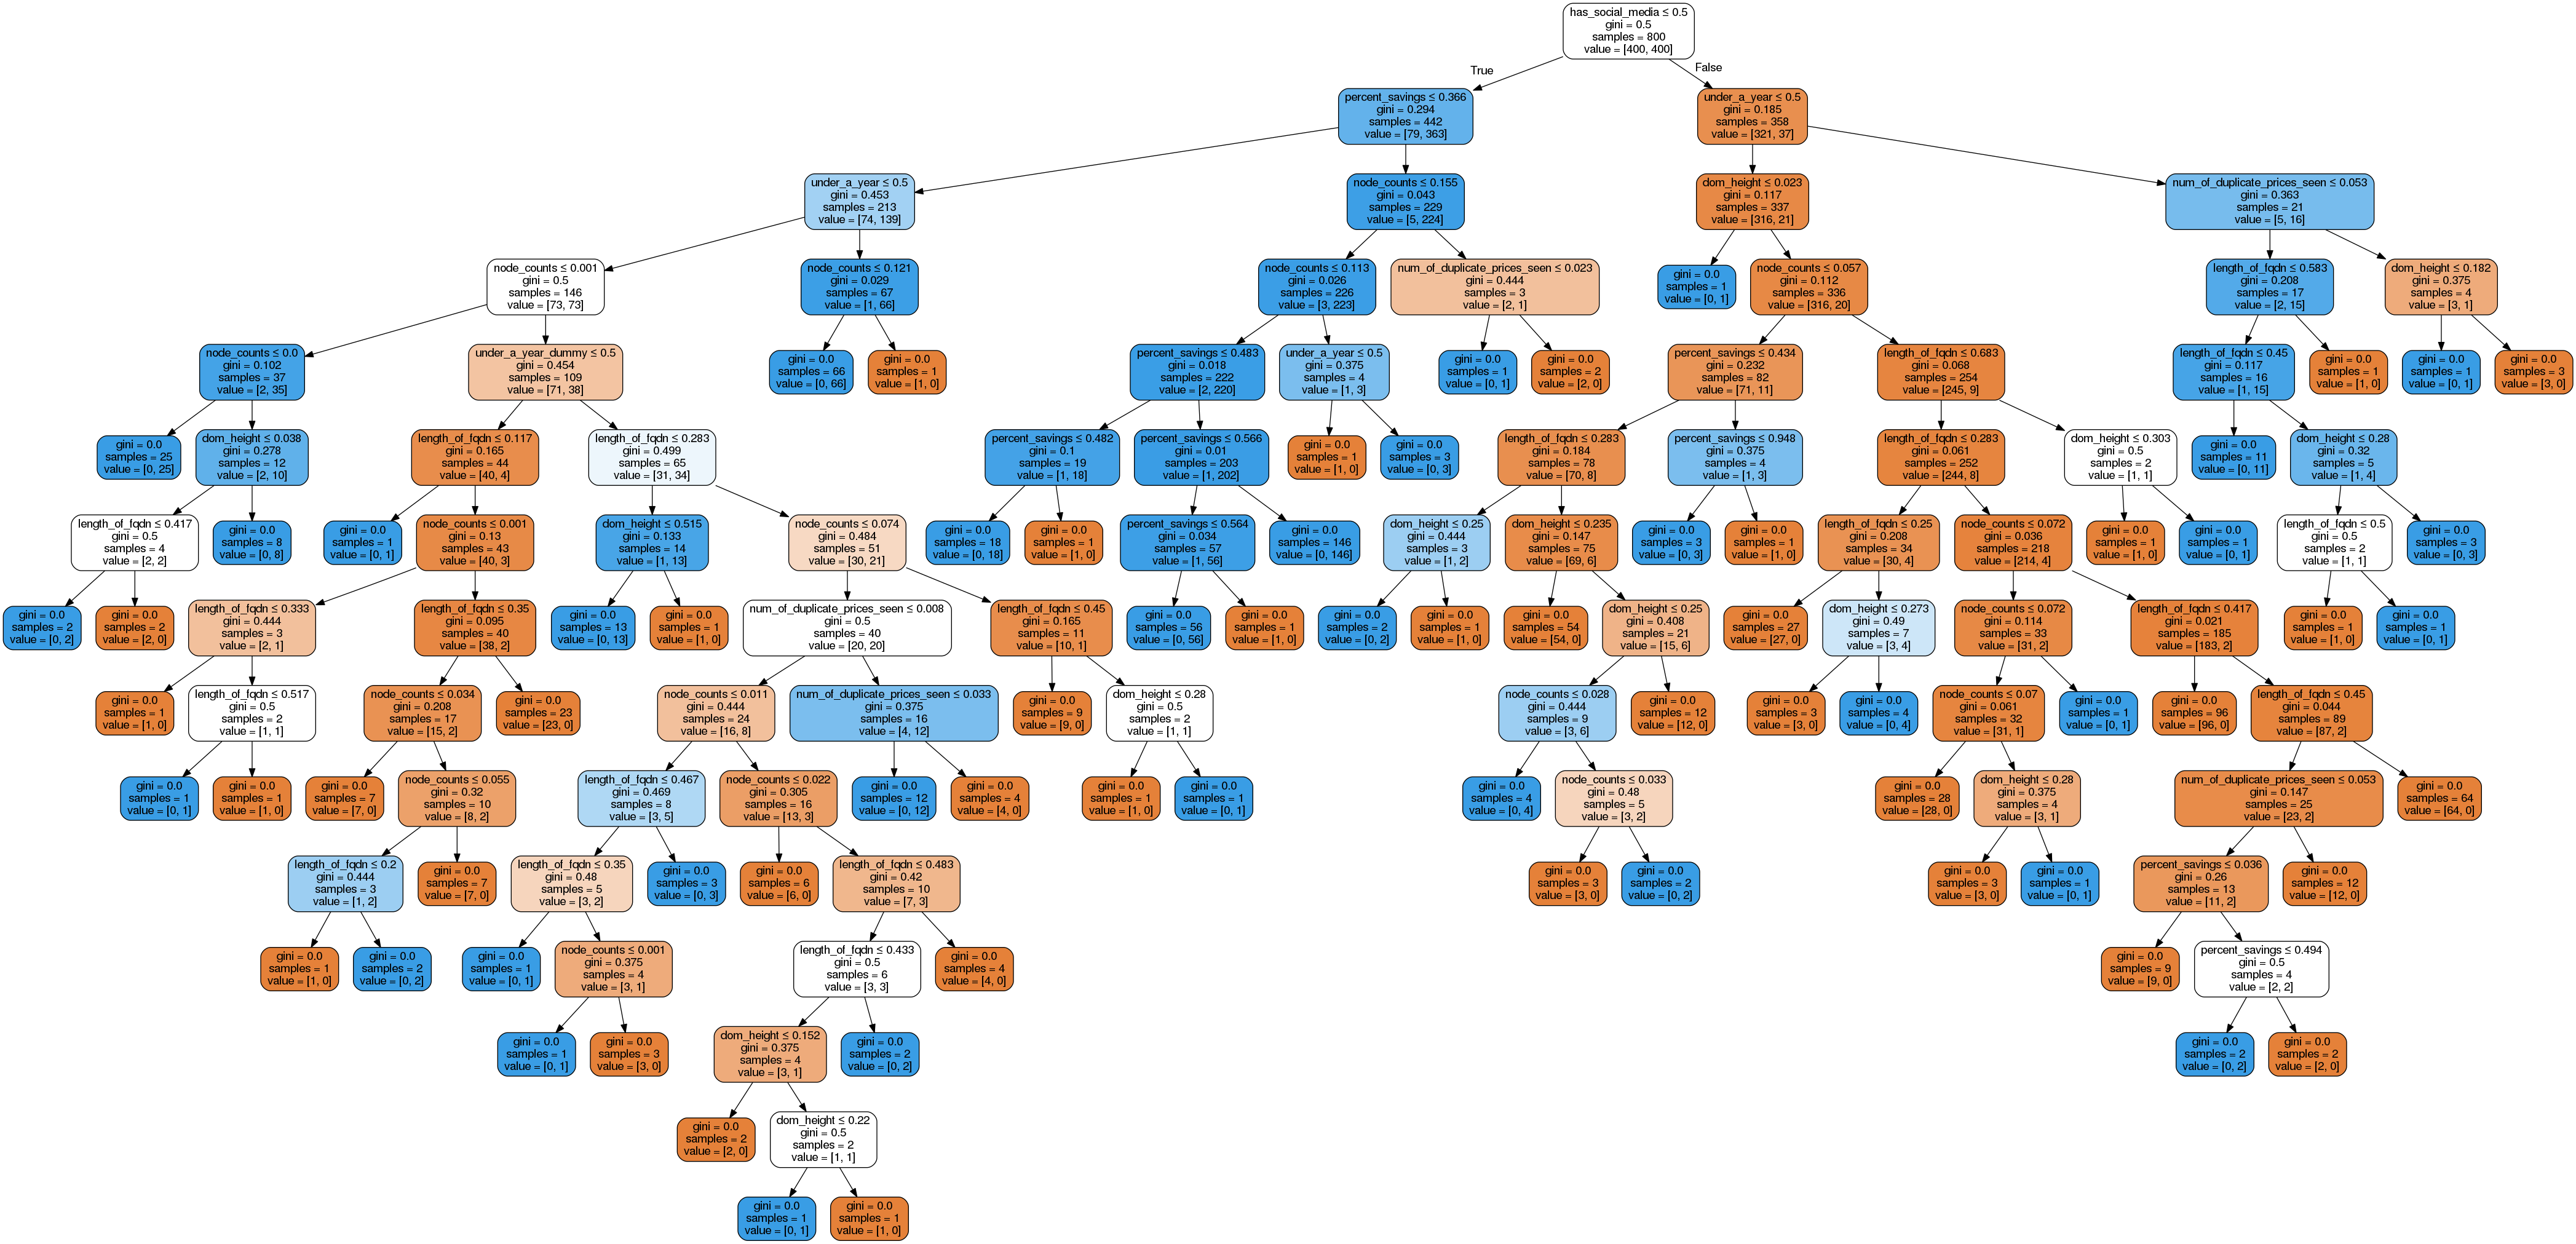

In [62]:
from IPython.display import Image
import pydotplus
myTree = utility_dt.classifier
df_X = df_800_drop_scaled.drop(columns=['label', 'url', 'hostname'])
df_Y = df_800_drop_scaled['label']
myTree.fit(X=df_X, y=df_Y)
dot_data = tree.export_graphviz(myTree, out_file=None, 
                         feature_names=df_X.columns,
                         class_names=None,  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
#graph.write_pdf('./myTree.pdf')
'''
with open("myTree.dot", 'w') as f:
    f = tree.export_graphviz(myTree, out_file=f)
'''
Image(graph.create_png())

### 2. Feature Selection: SVM <a name="feature_selection_svm"></a>

In [110]:
mySVM = utility_svm.classifier
df_X = df_800_all_scaled.drop(columns=['label', 'url', 'hostname'])

### Have no idea about how to use dual\_coef\_ for feature selection

In [111]:
mySVM.kernel = 'rbf'
mySVM.fit(X=df_X, y=df_Y)
mySVM.dual_coef_

array([[-2.        , -0.01517626, -2.        , -2.        , -2.        ,
        -2.        , -0.74014799, -2.        , -2.        , -2.        ,
        -2.        , -2.        , -2.        , -1.6952057 , -2.        ,
        -2.        , -2.        , -2.        , -2.        , -2.        ,
        -2.        , -2.        , -2.        , -2.        , -2.        ,
        -2.        , -2.        , -2.        , -2.        , -2.        ,
        -2.        , -2.        , -2.        , -2.        , -2.        ,
        -2.        , -2.        , -2.        , -2.        , -2.        ,
        -2.        , -2.        , -2.        , -1.79064373, -2.        ,
        -1.66019347, -2.        , -2.        , -2.        , -2.        ,
        -2.        , -2.        , -2.        , -1.46058004, -2.        ,
        -2.        , -2.        , -2.        , -2.        , -2.        ,
        -2.        , -2.        , -2.        , -2.        , -2.        ,
        -0.6596767 , -2.        , -2.        , -2. 

### Take out coefficients of SVM with linear kernel

In [114]:
mySVM.kernel = 'linear'
mySVM.fit(X=df_X, y=df_Y)
#coef_ is only available when using a linear kernel
svm_coefficients = pd.DataFrame(data=mySVM.coef_.T, columns=['coefficients'], index=df_X.columns)
svm_absolute_coefficients = abs(svm_coefficients).sort_values(by=['coefficients'],ascending=False)
svm_absolute_coefficients

,coefficients
under_a_year,3.486968
node_counts,3.261409
has_social_media,1.741033
has_mobile_app,1.688998
under_a_year_dummy,1.652245
num_of_duplicate_prices_seen,1.616657
dom_height,1.125960
large_iframes,1.125124
percent_savings,0.432262
length_of_fqdn,0.427741


### Try different kernels and coefficient thresholds for feature selection
* Conclusion: can reach better performance in recall but fail to reach good enough precision

In [127]:
def feature_selection_svm(kernel, threshold):
    mySVM.kernel = kernel
    above_threshold = (svm_absolute_coefficients['coefficients'] > threshold)
    columns_above_threshold = svm_absolute_coefficients.loc[above_threshold, :].index
    columns_above_threshold = columns_above_threshold.values.tolist()
    columns_above_threshold.append('label')
    df_above_threshold = df_800_all_scaled.loc[:, columns_above_threshold]
    
    return utility_svm.doABTesting(dataframe=df_above_threshold)
    
feature_selection_svm('poly', 1.5)

,test_accuracy,test_precision,test_recall,test_f1
all,86.875,82.039428,94.75,87.886959
w/o under_a_year,85.500,82.327198,90.75,86.258859
w/o node_counts,86.875,82.039428,94.75,87.886959
w/o has_social_media,75.250,97.297118,52.00,67.477622
w/o has_mobile_app,86.875,82.039428,94.75,87.886959
w/o num_of_duplicate_prices_seen,86.875,82.039428,94.75,87.886959
